In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
ads=pd.read_csv('data/ads.csv',index_col=['Time'],parse_dates=['Time'])
currency=pd.read_csv('data/currency.csv',index_col=['Time'],parse_dates=['Time'])

In [3]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [4]:
trace1=go.Scatter(x=ads.index.tolist(),y=ads.Ads.values,mode="lines",line=dict(color='rgb(63, 72, 204)'),name='Number of Ads',marker=dict(color='rgba(16,112,2,0.9)'))
data=[trace1]
layout = dict(title = 'Ads watched (Hourly Data)',yaxis=dict(linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),
              xaxis= dict(title= 'Time',linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),margin=go.Margin(l=50,r=30),paper_bgcolor='rgb(0, 0, 0)',
              plot_bgcolor='rgb(0, 0, 0)',font= {'color': '#FFFFFF'}
             )
fig = dict(data = data, layout = layout)
py.iplot(fig)

In [5]:
trace1=go.Scatter(x=currency.index.tolist(),y=currency.GEMS_GEMS_SPENT.values,
                 mode='lines',name='In-game currency spend',marker=dict(color='rgba(16,112,2,0.9)'))
data=[trace1]
layout=dict(title = 'In-game currency spend (Daily Data)',yaxis=dict(linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),
              xaxis= dict(title= 'Time',linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),margin=go.Margin(l=50,r=30),paper_bgcolor='rgb(0, 0, 0)',
              plot_bgcolor='rgb(0, 0, 0)',font= {'color': '#FFFFFF'}
             )
fig=go.Figure(data=data,layout=layout)
py.iplot(fig)

## Forecast Quality Metrics

* R_Squared
* Mean Absolute Error
* Median Absolute Error
* Mean Squared Error:  the most commonly used metric that gives a higher penalty to large errors and vice versa

* Mean Squared Logarithmic Error:  practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends

* Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management

In [6]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Moving Average

The future value of the measuring variable is generally calculated based on the average of k-past observations

In [7]:
def moving_average(series,n):
    """
    Calculate average of the last n observations
    """
    return(np.average(series[-n:]))
moving_average(ads,24) #prediction for the last observed day (past 24 hours)

116805.0

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [103]:
def plot_moving_average(series,col,window,plot_intervals=False,scale=1.96,plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    data=[]
    rolling_mean=series.rolling(window=window).mean()
    trace1=go.Scatter(x=rolling_mean.index.tolist(),y=rolling_mean[col].values[window:],mode="lines",name='Rolling Mean',marker=dict(color='rgba(16,112,2,0.9)'))
    data.append(trace1)
    if plot_intervals:
        mae=mean_absolute_error(series[window:],rolling_mean[window:])
        deviation=np.std(series[window:]-rolling_mean[window:])
        lower_bound=rolling_mean-(mae+scale*deviation)
        uppper_bound=rolling_mean+(mae+scale*deviation)
        
        trace_u=go.Scatter(x=uppper_bound.index,y=uppper_bound[col].values, line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
        dash = 'dash'),name='upper bound')
        
        trace_l=go.Scatter(x=lower_bound.index,y=lower_bound[col].values, line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
        dash = 'dash'),name='lower bound')
        data.append(trace_l)
        data.append(trace_u)
        
        if plot_anomalies:
            anomalies=pd.DataFrame(index=series.index,columns=series.columns)
            anomalies[series<lower_bound]=series[series<lower_bound]
            anomalies[series>uppper_bound]=series[series>uppper_bound]
            
            anomalies=(anomalies.dropna())
            trace_an=go.Scatter(x=anomalies.index.tolist(),y=anomalies[col].values, mode = "markers",marker=dict(color='rgba(255, 128, 2, 5)'),name='anomalies')
            data.append(trace_an)
            
    trace2=go.Scatter(x=series.index.tolist(),y=series[col].values,mode="lines",line=dict(color='rgb(63, 72, 204)'),name='Number of Ads',marker=dict(color='rgba(16,112,2,0.9)'))
    data.append(trace2)
    layout = dict(title = 'moving_average \n window size ={}'.format(window),yaxis=dict(linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),
              xaxis= dict(title= 'Time',linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),margin=go.Margin(l=50,r=30),paper_bgcolor='rgb(0, 0, 0)',
              plot_bgcolor='rgb(0, 0, 0)',font= {'color': '#FFFFFF'}
             )
    fig = dict(data = data, layout = layout)
    py.iplot(fig)

In [85]:
plot_moving_average(ads,'Ads',4)

In [86]:
plot_moving_average(ads,'Ads',12)

In [87]:
plot_moving_average(ads,'Ads',24)

When we applied daily smoothing on hourly data, we could clearly see the dynamics of ads watched. During the weekends, the values are higher (more time to play on the weekends) while fewer ads are watched on weekdays.

In [90]:
plot_moving_average(ads,'Ads',4,plot_intervals=True)

In [91]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

In [104]:
plot_moving_average(ads_anomaly,'Ads',4,plot_anomalies=True,plot_intervals=True)#

In [105]:
plot_moving_average(currency,'GEMS_GEMS_SPENT',7,plot_intervals=True,plot_anomalies=True)

Oh no, this was not as great! Here, we can see the downside of our simple approach -- it did not capture the monthly seasonality in our data and marked almost all 30-day peaks as anomalies. If you want to avoid false positives, it is best to consider more complex models.

**Weighted average** is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.

In [107]:
def weighted_average(series,weights):
    
    """
    Calculates weighted average on series
    """
    result=0.0
    weights.reverse()
    for n in range(len(weights)):
        result+=series.iloc[-n-1]*weights[n]
    return float(result)

In [108]:
weighted_average(ads,[0.6,0.3,0.1])

98423.0

### Exponential smoothing

Now, let's see what happens if, instead of weighting the last k values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:

y^t=α⋅yt+(1−α)⋅y^t−1

Here the model value is a weighted average between the current true value and the previous model values. The α weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller α is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by (1−α) each time, which already contains a multiplication by (1−α) of previous model values.

In [109]:
def exponential_smoothing(series,alpha):
    """
    series - dataset with timestamps
    alpha - float[0.0,1.0], smoothing parameter
    """
    
    result=[series[0]]
    
    for n in range(1,len(series)):
        result.append(alpha*series[n]+(1-alpha)*result[n-1])
    return result

In [121]:
def plot_exponential_smoothing(series,col,alphas):
    data=[]
    trace1=go.Scatter(x=series.index.tolist(),y=series[col].values,mode="lines",line=dict(color='rgb(63, 72, 204)'),name='Number of Ads',marker=dict(color='rgba(16,112,2,0.9)'))
    data.append(trace1)
    for alpha in alphas:
        result=exponential_smoothing(series[col],alpha)
        trace=go.Scatter(x=series.index,y=result,mode="lines",name='Alpha: {}'.format(alpha))
        data.append(trace)

    layout = dict(title = 'Exponential Smoothing',yaxis=dict(linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),
              xaxis= dict(title= 'Time',linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),margin=go.Margin(l=50,r=30),paper_bgcolor='rgb(0, 0, 0)',
              plot_bgcolor='rgb(0, 0, 0)',font= {'color': '#FFFFFF'}
             )
    fig = dict(data = data, layout = layout)
    py.iplot(fig)

In [122]:
plot_exponential_smoothing(ads,'Ads',[0.3,0.05])

In [123]:
plot_exponential_smoothing(currency,'GEMS_GEMS_SPENT',[0.3,0.05])

### Double Exponential Smoothing
Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) ℓ and slope (i.e. trend) b. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

ℓx=αyx+(1−α)(ℓx−1+bx−1)

bx=β(ℓx−ℓx−1)+(1−β)bx−1

y^x+1=ℓx+bx

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the β coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [124]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [128]:
def plot_DoubleExponential_Smoothing(series,col, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    data=[]
    trace1=go.Scatter(x=series.index.tolist(),y=series[col].values,mode="lines",line=dict(color='rgb(63, 72, 204)'),name='Number of Ads',marker=dict(color='rgba(16,112,2,0.9)'))
    data.append(trace1)
    
    for alpha in alphas:
        for beta in betas:
            result=double_exponential_smoothing(series[col],alpha,beta)
            trace=go.Scatter(x=series.index,y=result,mode="lines",name='Alpha , Beta: {},{}'.format(alpha,beta))
            data.append(trace)
    
    layout = dict(title = 'Double Exponential Smoothing',yaxis=dict(linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),
              xaxis= dict(title= 'Time',linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),margin=go.Margin(l=50,r=30),paper_bgcolor='rgb(0, 0, 0)',
              plot_bgcolor='rgb(0, 0, 0)',font= {'color': '#FFFFFF'}
             )
    fig = dict(data = data, layout = layout)
    py.iplot(fig)

In [129]:
plot_DoubleExponential_Smoothing(ads,'Ads',alphas=[0.9,0.02],betas=[0.9,0.02])

In [130]:
plot_DoubleExponential_Smoothing(currency,'GEMS_GEMS_SPENT',alphas=[0.9,0.02],betas=[0.9,0.02])

Now we have to tune two parameters: α and β. The former is responsible for the series smoothing around the trend, the latter for the smoothing of the trend itself. The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be. Certain combinations of the parameters may produce strange results, especially if set manually. We'll look into choosing parameters automatically in a bit; before that, let's discuss triple exponential smoothing.

### Triple exponential smoothing a.k.a. Holt-Winters
We've looked at exponential smoothing and double exponential smoothing. This time, we're going into triple exponential smoothing.

As you could have guessed, the idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:

ℓx=α(yx−sx−L)+(1−α)(ℓx−1+bx−1)

bx=β(ℓx−ℓx−1)+(1−β)bx−1

sx=γ(yx−ℓx)+(1−γ)sx−L

y^x+m=ℓx+mbx+sx−L+1+(m−1)modL

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done here. Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary m future steps ahead, which is very encouraging.


he intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done here. Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary m future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

y^maxx=ℓx−1+bx−1+sx−T+m⋅dt−T

y^minx=ℓx−1+bx−1+sx−T−m⋅dt−T

dt=γ∣yt−y^t∣+(1−γ)dt−T,

where T is the length of the season, d is the predicted deviation. Other parameters were taken from triple exponential smoothing. You can read more about the method and its applicability to anomaly detection in time series here.

In [131]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

### Time series cross validation

Before we start building a model, let's first discuss how to estimate model parameters automatically.

There is nothing unusual here; as always, we have to choose a loss function suitable for the task that will tell us how closely the model approximates the data. Then, using cross-validation, we will evaluate our chosen loss function for the given model parameters, calculate the gradient, adjust the model parameters, and so on, eventually descending to the global minimum.

You may be asking how to do cross-validation for time series because time series have this temporal structure and one cannot randomly mix values in a fold while preserving this structure. With randomization, all time dependencies between observations will be lost. This is why we will have to use a more tricky approach in optimizing the model parameters. I don't know if there's an official name to this, but on CrossValidated, where one can find all answers but the Answer to the Ultimate Question of Life, the Universe, and Everything, the proposed name for this method is "cross-validation on a rolling basis".

The idea is rather simple -- we train our model on a small segment of the time series from the beginning until some t, make predictions for the next t+n steps, and calculate an error. Then, we expand our training sample to t+n value, make predictions from t+n until t+2∗n, and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as n will fit between the initial training sample and the last observation.

In [132]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient.

In [212]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
Wall time: 2.53 s


In [215]:
def plot_holt_winters(series,col,plot_intervals=False,plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    data=[]
    trace1=go.Scatter(x=np.arange(len(model.result)),y=series[col].values,mode="lines",line=dict(color='rgb(63, 72, 204)'),name='Actual Data',marker=dict(color='rgba(16,112,2,0.9)'))
    data.append(trace1)
    error=mean_absolute_percentage_error(series[col].values,model.result[:len(series)])
    trace2=go.Scatter(x=np.arange(len(model.result)),y=model.result,mode="lines",name='Model Predicted')
    data.append(trace2)
    if plot_anomalies:
        anomalies=pd.DataFrame(np.array([np.NaN]*len(series)),columns=[col])
        anomalies[col][series[col].values<model.LowerBond[:len(series)]] = \
            series[col].values[series[col].values<model.LowerBond[:len(series)]].ravel()
        anomalies[col][series[col].values>model.UpperBond[:len(series)]] = \
            series[col].values[series[col].values>model.UpperBond[:len(series)]].ravel()
        
        anomalies=(anomalies.dropna())
        trace_an=go.Scatter(x=anomalies.index.tolist(),y=anomalies[col].values, mode = "markers",marker=dict(color='rgba(255, 255, 255, 5)'),name='anomalies')
        data.append(trace_an)
    
    if plot_intervals:
        
        trace_u=go.Scatter(x=np.arange(len(model.result)),y=model.UpperBond,mode='lines',line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
        dash = 'dash'),name='upper bound')
        data.append(trace_u)
        trace_l=go.Scatter(x=np.arange(len(model.result)),y=model.LowerBond,mode='lines',line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
        dash = 'dash'),name='lower bound')
        data.append(trace_l)
        
    layout = dict(title = 'Holt Winters Model with MAE = {0:.2f}%'.format(error),yaxis=dict(linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),
              xaxis= dict(title= 'Time',linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),margin=go.Margin(l=50,r=30),paper_bgcolor='rgb(0, 0, 0)',
              plot_bgcolor='rgb(0, 0, 0)',font= {'color': '#FFFFFF'},shapes= [
        # Line Vertical
        {
            'type': 'line',
            'x0': len(series),
            'y0': min(model.LowerBond),
            'x1': len(series),
            'y1': max(model.UpperBond),
            'line': {
                'color': 'rgb(55, 128, 191)',
                'width': 3,
                'dash': 'dashdot'
            },
        },{
            'type': 'rect',
            # x-reference is assigned to the x-values
            'xref': 'x',
            # y-reference is assigned to the plot paper [0,1]
            'yref': 'paper',
            'x0': len(series)-20,
            'y0': min(model.LowerBond),
            'x1': len(model.result),
            'y1': max(model.UpperBond),
            'fillcolor': '#ffffff',
            'opacity': 0.4,
            'line': {
                'width': 0,
            }
        },]
             )
    fig = dict(data = data, layout = layout)
    py.iplot(fig)
        

In [216]:
plot_holt_winters(ads,'Ads')

In [217]:
plot_holt_winters(ads,'Ads',plot_intervals=True,plot_anomalies=True)

In [222]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
Wall time: 3.83 s


In [223]:
plot_holt_winters(currency,'GEMS_GEMS_SPENT')

In [224]:
plot_holt_winters(currency,'GEMS_GEMS_SPENT',plot_intervals=True,plot_anomalies=True)

### Econometric approach

Before we start modeling, we should mention such an important property of time series: stationarity.

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called homoscedasticity)The covariance function does not depend on time; it should only depend on the distance between observations. You can see this visually on the images in the post by Sean Abu:

So why is stationarity so important? Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

So, in order to combat non-stationarity, we have to know our enemy, so to speak. Let's see how we can detect it. We will look at white noise and random walks to learn how to get from one to another for free.

White noise chart:

In [229]:
white_noise=np.random.normal(size=1000)
trace=go.Scatter(x=np.arange(len(white_noise)),y=white_noise,mode='lines',name='white_noise')
layout = dict(title = 'White Noise',yaxis=dict(linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),
              xaxis= dict(title= 'Time',linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),margin=go.Margin(l=50,r=30),paper_bgcolor='rgb(0, 0, 0)',
              plot_bgcolor='rgb(0, 0, 0)',font= {'color': '#FFFFFF'}
             )
fig=go.Figure(data=[trace],layout=layout)
py.iplot(fig)

In [232]:
def plot_Process(n_samples=1000,rho=0):
    x=w=np.random.normal(size=n_samples)
    
    for t in range(n_samples):
        x[t]=rho*x[t-1]+w[t] # new value is generated based on each subsequent values
    
    trace=go.Scatter(x=np.arange(len(x)),y=x)
    data=[trace]
    layout=dict(title = 'Rho {} Dickey Fuller p-value: {}'.format(rho,round(sm.tsa.adfuller(x)[1],3)),yaxis=dict(linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),
              xaxis= dict(title= 'Time',linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),margin=go.Margin(l=50,r=30),paper_bgcolor='rgb(0, 0, 0)',
              plot_bgcolor='rgb(0, 0, 0)',font= {'color': '#FFFFFF'}
             )
    fig=go.Figure(data=data,layout=layout)
    py.iplot(fig)

for rho in [0,0.6,0.9,1]:
    plot_Process(rho=rho)

On the first plot, you can see the same stationary white noise as before. On the second plot with ρ increased to 0.6, wider cycles appeared, but it still appears stationary overall. The third plot deviates even more from the 0 mean but still oscillates about the mean. Finally, with ρ=1, we have a random walk process i.e. a non-stationary time series.

This happens because, after reaching the critical value, the series xt=ρxt−1+et does not return to its mean value. If we subtract xt−1 from both sides, we will get xt−xt−1=(ρ−1)xt−1+et, where the expression on the left is referred to as the first difference. If ρ=1, then the first difference gives us stationary white noise et. This is the main idea behind the Dickey-Fuller test for stationarity of time series (testing the presence of a unit root). If we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1. The null hypothesis of the test is that the time series is non-stationary, which was rejected on the first three plots and finally accepted on the last one. We have to say that the first difference is not always enough to get a stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots). In such cases, the augmented Dickey-Fuller test is used, which checks multiple lags at once.

We can fight non-stationarity using different approaches: various order differences, trend and seasonality removal, smoothing, and transformations like Box-Cox or logarithmic.

In [236]:
def tsplot(y,lags=None,figsize=(15,8),style='ggplot'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
         y = pd.Series(y)
            
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        # time series plot
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        #auto-correlation plot
        acf_ax = plt.subplot2grid(layout, (1, 0))
        #partial auto-correlation plot
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1] # p value
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax) # acf calculation and plotting
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)# pacf calculation and plotting
        plt.tight_layout()

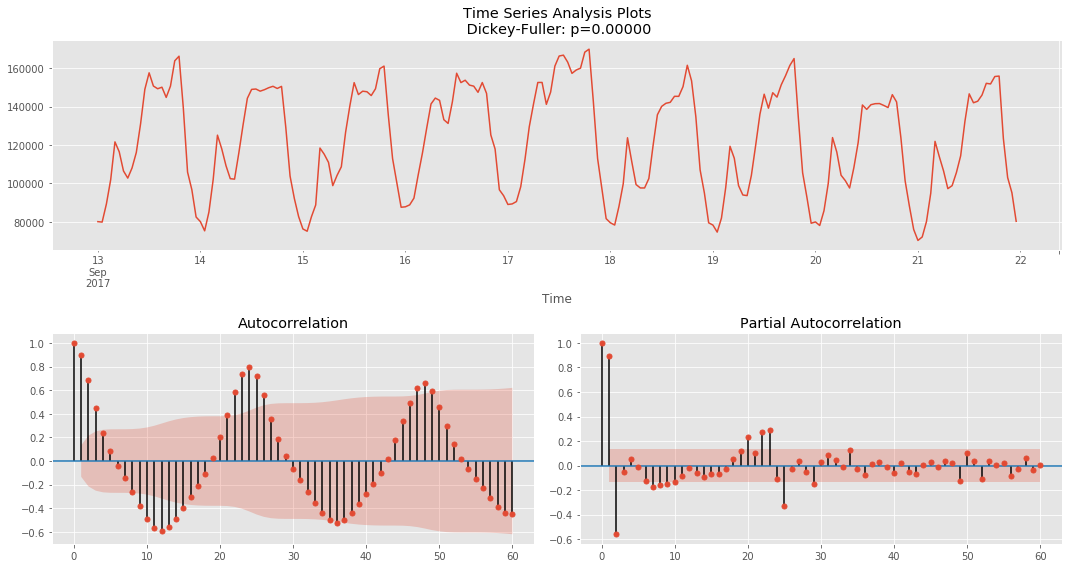

In [237]:
tsplot(ads.Ads,lags=60)

Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. Actually, we can see this on the plot itself -- we do not have a visible trend, so the mean is constant and the variance is pretty much stable. The only thing left is seasonality, which we have to deal with prior to modeling. To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

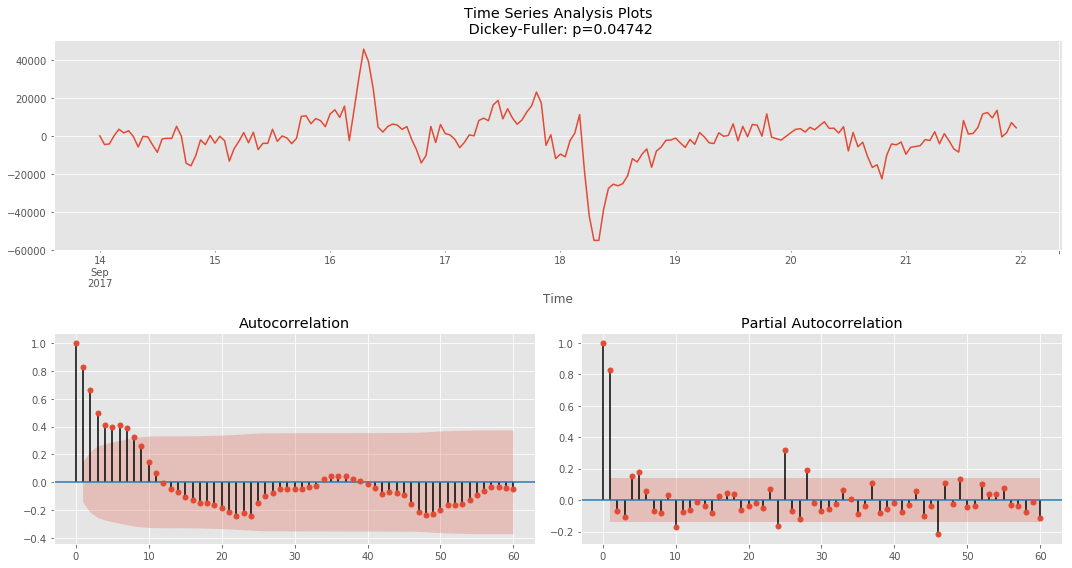

In [238]:
ads_diff=ads.Ads-ads.Ads.shift(24) # seasonal differ of 24 hrs
tsplot(ads_diff[24:],lags=60)

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

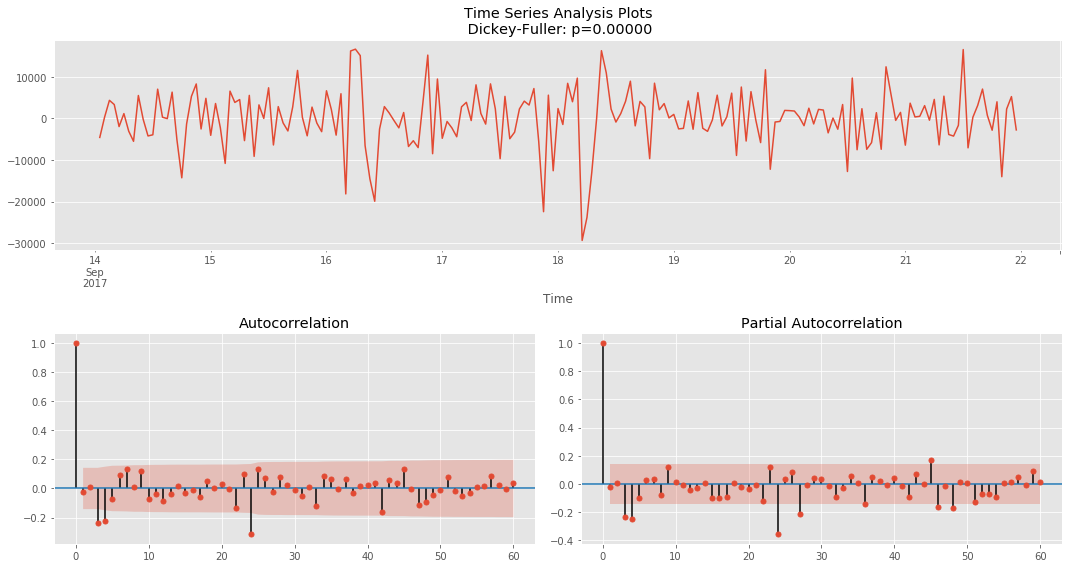

In [239]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Perfect! Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

### ARIMA-family Crash-Course
We will explain this model by building up letter by letter. SARIMA(p,d,q)(P,D,Q,s), Seasonal Autoregression Moving Average model:

AR(p) - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as p. To determine the initial p, you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.
MA(q) - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as q. The initial value can be found on the ACF plot with the same logic as before.
Let's combine our first 4 letters:

AR(p)+MA(q)=ARMA(p,q)
What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

I(d) - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.
Adding this letter to the four gives us the ARIMA model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

S(s) - this is responsible for seasonality and equals the season period length of the series
With this, we have three parameters: (P,D,Q)
P - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial P should be 2.

Q - similar logic using the ACF plot instead.

D - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

Now that we know how to set the initial parameters, let's have a look at the final plot once again and set the parameters:

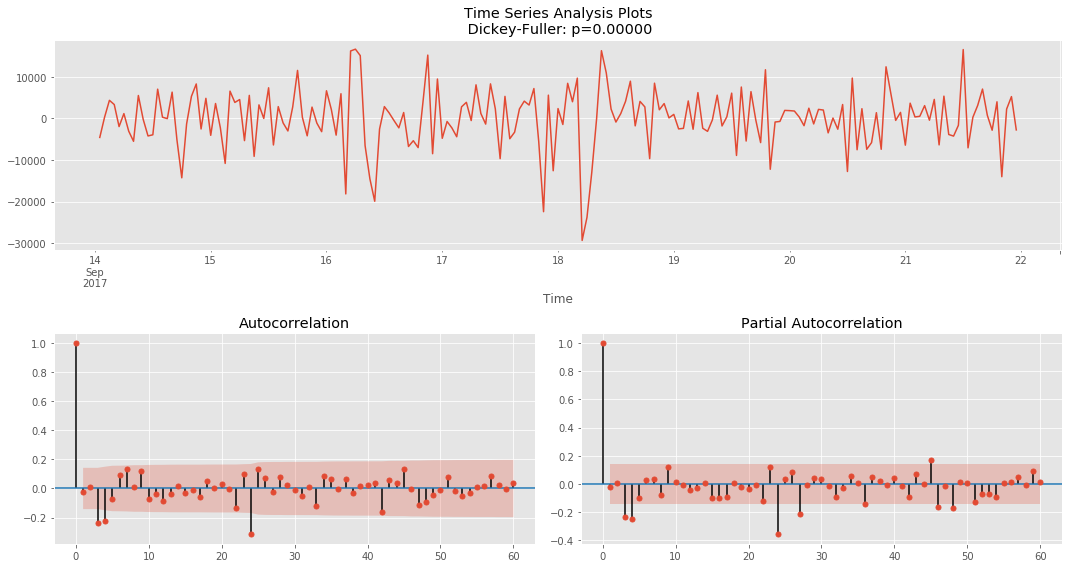

In [240]:
tsplot(ads_diff[24+1:], lags=60)

* p is most probably 4 since it is the last significant lag on the PACF, after which, most others are not significant.

* d is 1 because of first difference

* q is 4 because of similar logic

* P is 2 from PACF with 24 hrs seasonality

* D is 1 because 1 seasonal difference is performed

* Q is 1. the 24h lag term in ACF plot 

In [241]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [243]:
def optimizeSARIMA(parameters_list,d,D,s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    results=[]
    best_aic=float("inf")
    
    for param in tqdm_notebook(parameters_list):
    # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads,order=(param[0],d,param[1]),
                                           seasonal_order=(param[2],D,param[3],s)).fit(disp=-1)
        except:
            continue
        
        aic=model.aic
        # saving best model and AIC and parameters
        if aic < best_aic:
            best_model=model
            best_aic=aic
            best_param=param
        results.append([param,model.aic])
    
    result_table=pd.DataFrame(results)
    result_table.columns=['parameter','aic']
    
    #sorting in ascending order, the lower AIC is the better
    
    result_table=result_table.sort_values(by='aic',ascending=True).reset_index(drop=True)
    return result_table

In [244]:
%%time

result_table=optimizeSARIMA(parameters_list,d,D,s)

HBox(children=(IntProgress(value=0, max=36), HTML(value='')))


Wall time: 22.4 s


In [245]:
result_table.head()

,parameter,aic
0,"(4, 2, 1, 1)",3890.279587
1,"(4, 2, 0, 1)",3899.073562
2,"(4, 2, 1, 0)",3910.927747
3,"(4, 2, 0, 0)",3927.568225


In [247]:
p, q, P, Q = result_table.parameter[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(4, 1, 2)x(1, 1, 1, 24)   Log Likelihood               -1936.140
Date:                            Mon, 07 May 2018   AIC                           3890.280
Time:                                    21:46:39   BIC                           3920.657
Sample:                                09-13-2017   HQIC                          3902.552
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4191      0.796      0.527      0.598      -1.141       1.979
ar.L2         -0.2909      0.484   

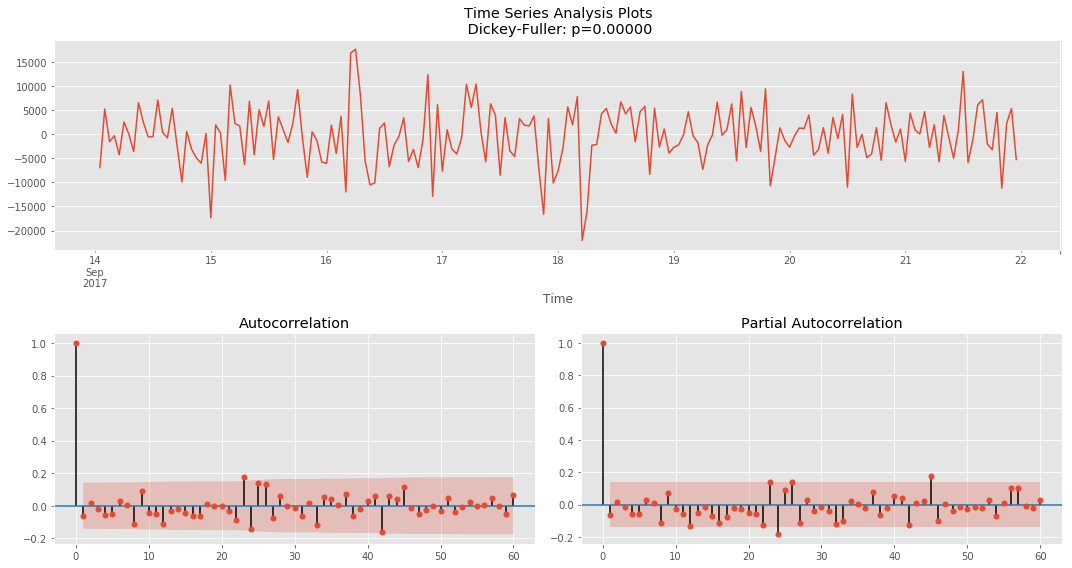

In [248]:
tsplot(best_model.resid[24+1:], lags=60)

It is clear that the residuals are stationary, and there are no apparent autocorrelations. Let's make predictions using our model.

In [268]:
def plotSARIMA(series,model,n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    
    # adding model values
    
    data=series.copy()
    data.columns=['actual']
    data['arima_model']=model.fittedvalues
    # making a shift of s+d steps because these values were unobserved because of seasonal difference and 1st difference
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward
    
    forecast=model.predict(start=data.shape[0],end=data.shape[0]+n_steps)
    forecast=data.arima_model.append(forecast)
    
    error=mean_absolute_percentage_error(data['actual'][s+d:],data['arima_model'][s+d:])
    # plots
    '''
    plt.figure(figsize=(15, 7))
    plt.style.use('bmh')
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    '''


    trace1=go.Scatter(x=data.index.tolist(),y=data['actual'].values,mode='lines',name='actual_data')
    trace2=go.Scatter(x=forecast[s+d:].index.tolist(),y=forecast[s+d:].values,mode='lines',name='forecasted')
    data=[trace1,trace2]
    layout=dict(title = 'SARIMAX model with MAE = {0:.2f}%'.format(error),yaxis=dict(linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),
              xaxis= dict(title= 'Time',linecolor='rgba(255,255,255, 0.8)',showgrid=True,gridcolor='rgba(255,255,255,0.2)'),margin=go.Margin(l=50,r=30),paper_bgcolor='rgb(0, 0, 0)',
              plot_bgcolor='rgb(0, 0, 0)',font= {'color': '#FFFFFF'},shapes= [
        # Line Vertical
        {
            'type': 'line',
            'x0': series.index.tolist()[-1],
            'y0': 40000,
            'x1': series.index.tolist()[-1],
            'y1': 180000,
            'line': {
                'color': 'rgb(55, 128, 191)',
                'width': 3,
                'dash': 'dashdot'
            }}])
    fig=go.Figure(data=data,layout=layout)
    py.iplot(fig)

   

In [269]:
plotSARIMA(ads, best_model, 50)

In the end, we got very adequate predictions. Our model was wrong by 4.01% on average, which is very, very good. However, the overall costs of preparing data, making the series stationary, and selecting parameters might not be worth this accuracy.